# Challange Bankaya
Este Notebook está enfocada en la resolución de un problema plantado por Bankaya

## Descripción del problema
**RISK MODEL CALLENGE:** El problema se centra en la necesidad de Bankaya de poner hacer una clasificación correcta de clientes (buen cliente y mal cliente) que le permite minimzar los riesgos en la colocación de créditos.

**La primera parte del reto** se centra en la creación de un modelo que permita minimizar  dichos riesgos.  Esta etapa se puede abordar con una clasificación binaria en la que entrenemos el modelo con datos etiquetadas de "buen cliente"   y "mal cliente" y con dicho datos hacer clasificaciones futuras. Existe una amplia variedad de modelos que podríamos usar para abordar este tipo de problemas. Dado que los datos que usaremos son tabulares optaremos por proponer 2 modelos los cuales son XGboost  y  regresión logistica.

**La segunda parte del reto** se centra simplemente en una recomendación de como utilizar este modelo para asginar tasas de interés a cada cliente.


**IMPORTANTE:** Dado que ya se esta planteando que exista distintas tasas de interés optaremos

**NOTAS IMPORTANTES:**
1) No todos los clientes en el main_dataset tienen historial en el credit_reports

**CARGA DE LIBRERIAS**

In [1]:
import pandas as pd
import duckdb # Me permite interactuar con sentencias sql en mis pandas df
import plotly.express as px # Visualizaciones
from datetime import datetime
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

## 1) Lectura de datos y análisis inicial


### 1.1) Lectura de datos

In [2]:
main_dataset   = pd.read_parquet("main_dataset.parquet", dtype_backend="pyarrow") # Usar el nuevo backedn de incluido desde pandas 2.0 puede minimizar hasta 3 veces el espacio en memoria que demanda en pandas DF  (esto se nota principalmente en archivos grandes)
main_dataset

,customer_id,loan_id,ACC_CREATION_DATETIME,APPLICATION_DATETIME,LOAN_ORIGINATION_DATETIME,max_days_late,target,account_to_application_days,n_sf_apps,first_app_date,last_app_date,n_bnpl_apps,n_bnpl_approved_apps,first_bnpl_app_date,last_bnpl_app_date,n_inquiries_l3m,n_inquiries_l6m
0,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25 00:00:00,2022-04-25 00:00:00,1.0,0.0,2022-04-26 02:15:17.742000,2022-04-26 02:15:17.742000,91.0,91.0
1,5190,2,2022-04-26 09:57:25,2022-04-26 07:00:00,2022-12-22 18:03:32,2,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,5194,3,2022-04-26 12:22:35,2022-04-26 07:00:00,2022-08-09 17:31:05,4,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,3978,4,2022-03-09 11:26:55,2022-04-26 07:00:00,2022-11-11 19:48:08,2,0,47,1.0,2022-03-17 00:00:00,2022-03-17 00:00:00,2.0,0.0,2022-03-19 22:02:50.555000,2022-03-09 16:41:49.675000,13.0,13.0
4,4535,5,2022-04-01 14:28:42,2022-04-26 07:00:00,2022-07-24 12:07:15,2,0,24,1.0,2022-04-01 00:00:00,2022-04-01 00:00:00,1.0,0.0,2022-04-01 19:37:56.185000,2022-04-01 19:37:56.185000,21.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14449,14452,14450,2023-05-15 12:02:51,2023-05-15 07:00:00,2023-05-21 14:56:30,5,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
14450,14453,14451,2023-05-16 12:54:39,2023-05-16 07:00:00,2023-05-19 21:07:56,0,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
14451,14454,14452,2023-05-19 19:55:04,2023-05-19 07:00:00,2023-05-22 15:14:50,0,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
14452,768,14453,2021-06-28 14:36:50,2023-05-22 07:00:00,2023-05-26 07:12:16,0,0,692,<NA>,<NA>,<NA>,3.0,0.0,2023-05-20 17:15:47,2023-05-17 15:20:48,10.0,10.0


**BREVE DESCRIPCIÓN:** Cada registro de este dataset corresponde al primer credito de cada cliente, adicionalmente este dataset contiene una variable objetivo, esta variable objetivo es una variable binaria que corresponde a buen o mal cliente

In [3]:
# Información externa de buro de crédito
credit_reports = pd.read_parquet("credit_reports.parquet", dtype_backend="pyarrow")
credit_reports
# El cliente ID aparece varias veces, contiene registros del buro de crédito de varias consultas a lo largo del tiempo por lo que puede variar el estatus o calidad crediticia de la persona

,customer_id,INQUIRY_TIME,CDC_INQUIRY_ID,INQUIRY_DATE,PREVENTION_KEY,CURRENCY,MAX_CREDIT,CREDIT_LIMIT,PAYMENT_AMOUNT,UPDATE_DATE,...,ACCOUNT_TYPE,RESPONSABILITY_TYPE,TOTAL_PAYMENTS,DELAYED_PAYMENTS,CURRENT_PAYMENT,WORST_DELAY,TOTAL_REPORTED_PAYMENTS,CURRENT_BALANCE,BALANCE_DUE,BALANCE_DUE_WORST_DELAY
0,4223,2022-04-01 00:32:36.689000+00:00,710278-27993a6e-2885-48d4-a753-9249e7022af1,2022-04-01 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,1244.0,9900.0,1244.0,2022-02-28 00:00:00,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),12.0,7,13,13.0,0,1244.0,1244.0,1244.0
1,4223,2022-04-01 00:32:36.689000+00:00,710278-27993a6e-2885-48d4-a753-9249e7022af1,2022-04-01 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,1722.0,9900.0,1722.0,2022-02-28 00:00:00,...,REVOLVENTE,INDIVIDUAL (TITULAR),0.0,3,13,13.0,0,1722.0,1722.0,1722.0
2,4223,2022-04-01 00:32:36.689000+00:00,710278-27993a6e-2885-48d4-a753-9249e7022af1,2022-04-01 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,6346.0,0.0,482.0,2022-03-28 00:00:00,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),16.0,0,V,0.0,0,943.0,0.0,0.0
3,3490,2022-02-15 02:30:22.086000+00:00,622857-6b4e9d95-7491-40c3-bccd-442de7f94c58,2022-02-15 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,11600.0,0.0,232.0,2022-02-01 00:00:00,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),100.0,4,01,1.0,0,6185.0,116.0,116.0
4,6486,2022-06-25 01:57:14.868000+00:00,875073-46a5f149-19db-4193-b92a-b8f41fb3e896,2022-06-25 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,2452.0,16800.0,2452.0,2021-09-30 00:00:00,...,REVOLVENTE,INDIVIDUAL (TITULAR),0.0,19,13,13.0,0,2452.0,2452.0,2452.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287351,12079,2022-12-24 22:21:36.102000+00:00,1053785-35891c8d-97ba-4dce-9f5f-e7bf8684473a,2022-12-24 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,1609.0,1609.0,634.0,2022-12-01 00:00:00,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),3.0,11,01,1.0,0,634.0,634.0,634.0
287352,12079,2022-12-24 22:21:36.102000+00:00,1053785-35891c8d-97ba-4dce-9f5f-e7bf8684473a,2022-12-24 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,248.0,248.0,263.0,2022-12-01 00:00:00,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),1.0,11,01,1.0,0,263.0,263.0,263.0
287353,12079,2022-12-24 22:21:36.102000+00:00,1053785-35891c8d-97ba-4dce-9f5f-e7bf8684473a,2022-12-24 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,3267.0,3267.0,1243.0,2022-12-01 00:00:00,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),3.0,10,03,3.0,0,3666.0,3666.0,3666.0
287354,12079,2022-12-24 22:21:36.102000+00:00,1053785-35891c8d-97ba-4dce-9f5f-e7bf8684473a,2022-12-24 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,496.0,496.0,189.0,2022-12-01 00:00:00,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),3.0,10,03,3.0,0,557.0,557.0,557.0


### 1.2) Análisis explotario de datos  (AED)
Antes de iniciar el tratamiento de los datos  es recomendable hacer una breve insepción y exploraación de los datos

#### 1.2.1) Coicidencia entre sets de datos
Veremos cuantos clientes tiene cada set de datos y en cuantos de ellos hay una coicidencia

In [4]:
print("Cantidad de clientes en el set de datos 'main_dataset':", len(main_dataset["customer_id"].unique()))
print("Cantidad de clientes en el 'credit_report':", len(credit_reports["customer_id"].unique()))

Cantidad de clientes en el set de datos 'main_dataset': 14454
Cantidad de clientes en el 'credit_report': 9249


**IMPORTANTE:**  Hay una diferencia importante en el número de clientes sin historial. Voy a tomar la desición de solo continuar con los clientes que cuentan con datos historicos para el proceso de entrenamiento. Esto dado la importancia en los datos contenidos en el credit_report

#### 1.2.2) Valores nulos
Exploración de registros nulos en ambos set de datos

In [5]:
# Inspección de valores nulos en el main dataset (datos internos de la empresa)
main_dataset.isnull().sum()

customer_id                       0
loan_id                           0
ACC_CREATION_DATETIME             0
APPLICATION_DATETIME              0
LOAN_ORIGINATION_DATETIME         0
max_days_late                     0
target                            0
account_to_application_days       0
n_sf_apps                      7648
first_app_date                 7648
last_app_date                  7648
n_bnpl_apps                    5715
n_bnpl_approved_apps           5715
first_bnpl_app_date            5715
last_bnpl_app_date             5715
n_inquiries_l3m                5371
n_inquiries_l6m                5371
dtype: int64

In [6]:
# Revision de valores nulos en el dataset de datos externos (buro de credito)
credit_reports.isnull().sum()  # Se observa valores nulos en varias columnas

customer_id                     0
INQUIRY_TIME                    0
CDC_INQUIRY_ID                 89
INQUIRY_DATE                   89
PREVENTION_KEY                 89
CURRENCY                       89
MAX_CREDIT                    182
CREDIT_LIMIT                 8357
PAYMENT_AMOUNT                 89
UPDATE_DATE                    89
LOAN_OPENING_DATE              89
LOAN_CLOSING_DATE           94747
WORST_DELAY_DATE           202698
REPORT_DATE                    89
LAST_PURCHASE_DATE           4142
LAST_PAYMENT_DATE           31677
PAYMENT_FREQUENCY              89
BUSINESS_TYPE                  89
CREDIT_TYPE                    89
ACCOUNT_TYPE                   89
RESPONSABILITY_TYPE            89
TOTAL_PAYMENTS              18645
DELAYED_PAYMENTS               89
CURRENT_PAYMENT                89
WORST_DELAY                  3210
TOTAL_REPORTED_PAYMENTS     41941
CURRENT_BALANCE                89
BALANCE_DUE                    89
BALANCE_DUE_WORST_DELAY        89
dtype: int64

#### 1.2.3) Valores duplicados
Inspección de valores duplicados en ambos set de datos

In [9]:
%%time
duplicados_por_columna = credit_reports.apply(lambda col: col.duplicated(keep='first').sum())
duplicados_por_columna # Este DF contiene un número importante de valores duplicados, la documentación menciona que

NotImplementedError: 

#### 1.2.4) Inspección de algunas variables en el dataset de credit_reports
Haremos una exploración de un par de variables con el fin de tener una mejor comprensión del comportamiento crediticio de los clientes.

Leyendo la documentación proporcionada me surge el interés por ver algunos puntos previos al tratamiento de datos, estos puntos son los siguientes:

- Cantidad de prestamos por tipo de credito solicitado (Variable CREDIT_TYPE)
- Cantidad de prestamos por plazo solicitados (Variable PAYMENT_FREQUENCY)
- Distribución de limites de crédito

##### 1.2.4.1) Cantidad de prestamos por tipo de crédito solicitado

In [45]:
# como no hay un ID del prestamos supondre que la persona abrio solo un credito en un dia por tipo de categoria, plazazo y tipo de crédito esto no es lo más optimo pues puede colarse errores pero me dará una idea de la distribucion de los tipos de crédito (lo hago asi porque no hay un ID_LOAN)

tipos_credito = duckdb.sql("SELECT DISTINCT ON (customer_id, LOAN_OPENING_DATE, PAYMENT_FREQUENCY, CREDIT_TYPE) * FROM credit_reports ORDER BY customer_id, LOAN_OPENING_DATE, PAYMENT_FREQUENCY, CREDIT_TYPE").to_df()

tipos_credito

,customer_id,INQUIRY_TIME,CDC_INQUIRY_ID,INQUIRY_DATE,PREVENTION_KEY,CURRENCY,MAX_CREDIT,CREDIT_LIMIT,PAYMENT_AMOUNT,UPDATE_DATE,...,ACCOUNT_TYPE,RESPONSABILITY_TYPE,TOTAL_PAYMENTS,DELAYED_PAYMENTS,CURRENT_PAYMENT,WORST_DELAY,TOTAL_REPORTED_PAYMENTS,CURRENT_BALANCE,BALANCE_DUE,BALANCE_DUE_WORST_DELAY
0,1,2022-06-16 18:06:37.677000-05:00,102-b978ce50-aa84-4910-92dd-b3c721e7d831,2022-06-16,SIN OBSERVACION,PESOS MEXICANOS,0.0,0.0,0.0,2022-05-31,...,SIN LIMITE PREESTABLECIDO,INDIVIDUAL (TITULAR),1.0,0.0,V,0.0,0.0,0.0,0.0,0.0
1,1,2022-06-16 18:06:37.677000-05:00,102-b978ce50-aa84-4910-92dd-b3c721e7d831,2022-06-16,CUENTA CANCELADA O CERRADA,PESOS MEXICANOS,26509.0,57340.0,0.0,2018-05-30,...,REVOLVENTE,INDIVIDUAL (TITULAR),NaN,0.0,V,0.0,NaN,0.0,0.0,0.0
2,1,2022-06-16 18:06:37.677000-05:00,102-b978ce50-aa84-4910-92dd-b3c721e7d831,2022-06-16,SIN OBSERVACION,PESOS MEXICANOS,2675.0,20000.0,0.0,2022-06-10,...,SIN LIMITE PREESTABLECIDO,INDIVIDUAL (TITULAR),NaN,0.0,V,0.0,NaN,0.0,0.0,0.0
3,1,2022-06-16 18:06:37.677000-05:00,102-b978ce50-aa84-4910-92dd-b3c721e7d831,2022-06-16,SIN OBSERVACION,PESOS MEXICANOS,25627.0,134000.0,0.0,2022-05-25,...,REVOLVENTE,INDIVIDUAL (TITULAR),NaN,1.0,V,1.0,NaN,0.0,0.0,0.0
4,1,2022-06-16 18:06:37.677000-05:00,102-b978ce50-aa84-4910-92dd-b3c721e7d831,2022-06-16,CUENTA CANCELADA O CERRADA,PESOS MEXICANOS,22710.0,50000.0,0.0,2018-01-24,...,REVOLVENTE,INDIVIDUAL (TITULAR),NaN,0.0,V,0.0,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262854,14416,2023-04-24 17:36:56.539000-06:00,1169801-55d3f904-d9ce-4ad2-bb39-457595c1859b,2023-04-24,CUENTA CANCELADA O CERRADA,PESOS MEXICANOS,4999.0,4999.0,0.0,2019-12-20,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),NaN,6.0,V,2.0,NaN,0.0,0.0,0.0
262855,14416,2023-04-24 17:36:56.539000-06:00,1169801-55d3f904-d9ce-4ad2-bb39-457595c1859b,2023-04-24,SIN OBSERVACION,PESOS MEXICANOS,121970.0,121970.0,121970.0,2023-03-31,...,SIN LIMITE PREESTABLECIDO,INDIVIDUAL (TITULAR),0.0,24.0,53,53.0,0.0,121970.0,121970.0,121970.0
262856,14416,2023-04-24 17:36:56.539000-06:00,1169801-55d3f904-d9ce-4ad2-bb39-457595c1859b,2023-04-24,SIN OBSERVACION,PESOS MEXICANOS,716.0,15600.0,13457.0,2023-02-28,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),12.0,7.0,22,30.0,0.0,13457.0,13457.0,4511.0
262857,14416,2023-04-24 17:36:56.539000-06:00,1169801-55d3f904-d9ce-4ad2-bb39-457595c1859b,2023-04-24,SIN OBSERVACION,PESOS MEXICANOS,9984.0,9984.0,0.0,2023-04-02,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),52.0,0.0,V,0.0,0.0,0.0,0.0,0.0


In [46]:
# Ahora agrupamos
tipos_credito = duckdb.sql("select count(CREDIT_TYPE) as Total_Creditos, CREDIT_TYPE from tipos_credito group by CREDIT_TYPE").to_df()
tipos_credito

,Total_Creditos,CREDIT_TYPE
0,59553,CREDITO AL CONSUMO
1,0,None
2,14,PRESTAMO PERSONAL BANCARIO
3,640,ARRENDAMIENTO
4,21460,LINEA DE CREDITO
5,11116,GRUPO SOLIDARIO
6,3,CONSOLIDACION
7,7,EQUIPO
8,6,PRESTAMO PARA ESTUDIANTE
9,120503,PRESTAMO PERSONAL


In [51]:
# Visualización
fig = px.pie(data_frame=tipos_credito, values='Total_Creditos', names='CREDIT_TYPE', title='Distribución por tipos de créditos (estimación)')
fig.update_traces(textposition='inside')

fig.show() # Podemoos ver que

##### 1.2.4.2) Cantidad de prestamos por plazo solicitado

In [59]:
# Nuevamente como no cuento con un ID de prestamo tendré que hacer una remoción de duplicados haciendo ciertas suposiciones para dar con un único registro de crédito, eliminando registros duplicados de las variables de: customer_id, loan_opening_date, payment_frecuency & credit_type

plazo_creditos = duckdb.sql("SELECT DISTINCT ON (customer_id, LOAN_OPENING_DATE, PAYMENT_FREQUENCY, CREDIT_TYPE) * FROM credit_reports ORDER BY customer_id, LOAN_OPENING_DATE, PAYMENT_FREQUENCY, CREDIT_TYPE").to_df()

plazo_creditos = duckdb.sql("select count(PAYMENT_FREQUENCY) as Frecuencia, PAYMENT_FREQUENCY from credit_reports group by PAYMENT_FREQUENCY").to_df()
plazo_creditos

,Frecuencia,PAYMENT_FREQUENCY
0,87712,SEMANAL
1,33675,QUINCENAL
2,425,ANUAL
3,50,DEDUCCION DEL SALARIO
4,124398,MENSUAL
5,22,SEMESTRAL
6,7019,PAGO MINIMO PARA CUENTAS REVOLVENTES
7,0,None
8,378,TRIMESTRAL
9,23425,UNA SOLA EXHIBICION


In [60]:
# Visualización
fig = px.pie(data_frame=plazo_creditos, values='Frecuencia', names='PAYMENT_FREQUENCY', title='Distribución por plazo de créditos (estimación)')
fig.update_traces(textposition='inside')

fig.show()

##### 1.2.4.3) Distribución de límites de crédito
Voy a suponer (no estoy del todo seguro que sea asi) que la variable "CREDIT_LIMIT" es independiente a un prestamo concreto, es decir el crédito limite sería el monto máximo de la linea de crétido que tengo  (independientemente si tengo varias lineas de crédito).
Otro tema es que en este caso me quedaré con el valor de CREDIT_LIMT de la ultima actualización del cliente ( es decir el esttus más acutal)

In [63]:
limite_credito = duckdb.sql("select * from credit_reports order by customer_id, UPDATE_DATE desc").to_df()
limite_credito # PAUSEMOS ESTO, necesito el ID del credito

,customer_id,INQUIRY_TIME,CDC_INQUIRY_ID,INQUIRY_DATE,PREVENTION_KEY,CURRENCY,MAX_CREDIT,CREDIT_LIMIT,PAYMENT_AMOUNT,UPDATE_DATE,...,ACCOUNT_TYPE,RESPONSABILITY_TYPE,TOTAL_PAYMENTS,DELAYED_PAYMENTS,CURRENT_PAYMENT,WORST_DELAY,TOTAL_REPORTED_PAYMENTS,CURRENT_BALANCE,BALANCE_DUE,BALANCE_DUE_WORST_DELAY
0,1,2022-06-16 18:06:37.677000-05:00,102-b978ce50-aa84-4910-92dd-b3c721e7d831,2022-06-16,SIN OBSERVACION,PESOS MEXICANOS,30534.0,80300.0,418.0,2022-06-11,...,REVOLVENTE,INDIVIDUAL (TITULAR),NaN,0.0,V,0.0,NaN,4800.0,0.0,0.0
1,1,2022-06-16 18:06:37.677000-05:00,102-b978ce50-aa84-4910-92dd-b3c721e7d831,2022-06-16,SIN OBSERVACION,PESOS MEXICANOS,22710.0,50000.0,625.0,2022-06-11,...,REVOLVENTE,INDIVIDUAL (TITULAR),NaN,0.0,V,0.0,NaN,611.0,0.0,0.0
2,1,2022-06-16 18:06:37.677000-05:00,102-b978ce50-aa84-4910-92dd-b3c721e7d831,2022-06-16,SIN OBSERVACION,PESOS MEXICANOS,2675.0,20000.0,0.0,2022-06-10,...,SIN LIMITE PREESTABLECIDO,INDIVIDUAL (TITULAR),NaN,0.0,V,0.0,NaN,0.0,0.0,0.0
3,1,2022-06-16 18:06:37.677000-05:00,102-b978ce50-aa84-4910-92dd-b3c721e7d831,2022-06-16,SIN OBSERVACION,PESOS MEXICANOS,39291.0,161000.0,578.0,2022-06-02,...,REVOLVENTE,INDIVIDUAL (TITULAR),NaN,0.0,V,0.0,NaN,12557.0,0.0,0.0
4,1,2022-06-16 18:06:37.677000-05:00,102-b978ce50-aa84-4910-92dd-b3c721e7d831,2022-06-16,SIN OBSERVACION,PESOS MEXICANOS,0.0,0.0,0.0,2022-05-31,...,SIN LIMITE PREESTABLECIDO,INDIVIDUAL (TITULAR),1.0,0.0,V,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287351,14416,2023-04-24 17:36:56.539000-06:00,1169801-55d3f904-d9ce-4ad2-bb39-457595c1859b,2023-04-24,SIN OBSERVACION,PESOS MEXICANOS,25500.0,25500.0,0.0,2011-03-31,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),12.0,0.0,V,0.0,0.0,0.0,0.0,0.0
287352,14416,2023-04-24 17:36:56.539000-06:00,1169801-55d3f904-d9ce-4ad2-bb39-457595c1859b,2023-04-24,SIN OBSERVACION,PESOS MEXICANOS,25500.0,25500.0,0.0,2011-03-31,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),12.0,0.0,V,0.0,0.0,0.0,0.0,0.0
287353,14416,2023-04-24 17:36:56.539000-06:00,1169801-55d3f904-d9ce-4ad2-bb39-457595c1859b,2023-04-24,SIN OBSERVACION,PESOS MEXICANOS,25500.0,25500.0,0.0,2011-03-31,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),12.0,0.0,V,0.0,0.0,0.0,0.0,0.0
287354,14416,2023-04-24 17:36:56.539000-06:00,1169801-55d3f904-d9ce-4ad2-bb39-457595c1859b,2023-04-24,SIN OBSERVACION,PESOS MEXICANOS,1.0,0.0,0.0,2010-10-31,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),18.0,0.0,V,0.0,0.0,0.0,0.0,0.0


#### 1.2.5) Inspección de algunas variables en el dataset de main_dataset


In [ ]:
### AQUI, tambien hacer algunas graficas referentes al dataset de main_dataset



**NOTA:** En el breve análisis sobre lo que vimos acá (algún descrubimento en los datos)

## 2) Tratamiento de datos
En este sección haremos un tratamiento más profundo de los datos, teniendo el objetivo de dejarlos listos para su uso en el modelo que vayamos a usar.

**NOTA:** Voy a tomar el dataset de *main_dataset* como base, este dataset es el que realmente contiene el comportamiento del cliente en el primer prestamo en bankaya. Este primer dataset de base lo voy a relacionar con la fuente externa de datos que es el dataset de *credit_reports*. Sin embargo, voy a tranformar radicalmente este dataset. Este último dataset contiene información historica de cada cliente (por lo que cada cliente puede aparecer en multiuples ocaciones en este dataset) voy a tranformalo todo eso para que este en un formato de un solo registro y capture lo que de momento a mi parecer puede significar las variables más prometedora de integrar


### 2.1) Tratamiento a credit reports

#### 2.1.1) Generación de ID crédito
Dado que no cuento con un ID de crédito voy a generar uno haciendo una serie de supuestos, que son los siguientes: un prestamo unico tendrá valores únicos en los siguientes campos:
- customer_id
- LOAN_OPENING_DATE
- PAYMENT_FREQUENCY
- BUSINESS_TYPE
- CREDIT_TYPE
- RESPONSABILITY_TYPE

In [106]:
# 1) Dropeo de duplicados
ID_loan = credit_reports.drop_duplicates(subset=["customer_id", "LOAN_OPENING_DATE", "PAYMENT_FREQUENCY", "BUSINESS_TYPE", "CREDIT_TYPE", "RESPONSABILITY_TYPE"]) # De acuerdo con mis supuestos en este punto tendriamos indentificados cada prestamos con un solo registro de él.

# 2) Seleccion de columnas de interés
ID_loan = ID_loan [["customer_id", "LOAN_OPENING_DATE", "PAYMENT_FREQUENCY", "BUSINESS_TYPE", "CREDIT_TYPE", "RESPONSABILITY_TYPE"]]
ID_loan["LOAN_ID"] = ID_loan.index
ID_loan

### ESTO AHORITA NO ESTA JALANDO

,customer_id,LOAN_OPENING_DATE,PAYMENT_FREQUENCY,BUSINESS_TYPE,CREDIT_TYPE,RESPONSABILITY_TYPE,LOAN_ID
0,4223,2019-08-30 00:00:00,MENSUAL,TIENDA DEPARTAMENTAL,APARATOS/MUEBLES,INDIVIDUAL (TITULAR),0
1,4223,2020-04-21 00:00:00,PAGO MINIMO PARA CUENTAS REVOLVENTES,TIENDA DEPARTAMENTAL,LINEA DE CREDITO,INDIVIDUAL (TITULAR),1
2,4223,2021-12-17 00:00:00,SEMANAL,BANCOS,PRESTAMO PERSONAL,INDIVIDUAL (TITULAR),2
3,3490,2021-03-02 00:00:00,SEMANAL,TIENDA DE ROPA,PRESTAMO PERSONAL,INDIVIDUAL (TITULAR),3
4,6486,2019-02-22 00:00:00,PAGO MINIMO PARA CUENTAS REVOLVENTES,TIENDA DEPARTAMENTAL,LINEA DE CREDITO,INDIVIDUAL (TITULAR),4
...,...,...,...,...,...,...,...
287351,12079,2020-12-22 00:00:00,MENSUAL,MICROFINANCIERA,CREDITO AL CONSUMO,INDIVIDUAL (TITULAR),287351
287352,12079,2021-02-14 00:00:00,MENSUAL,MICROFINANCIERA,CREDITO AL CONSUMO,INDIVIDUAL (TITULAR),287352
287353,12079,2021-02-17 00:00:00,MENSUAL,MICROFINANCIERA,CREDITO AL CONSUMO,INDIVIDUAL (TITULAR),287353
287354,12079,2021-02-17 00:00:00,MENSUAL,MICROFINANCIERA,CREDITO AL CONSUMO,INDIVIDUAL (TITULAR),287354


MERGE CON EL DATASET ORIGINAL

In [104]:
credit_reports = pd.merge(left=credit_reports, right=ID_loan, left_on=["customer_id", "LOAN_OPENING_DATE", "PAYMENT_FREQUENCY", "BUSINESS_TYPE", "CREDIT_TYPE", "RESPONSABILITY_TYPE"], right_on=["customer_id", "LOAN_OPENING_DATE", "PAYMENT_FREQUENCY", "BUSINESS_TYPE", "CREDIT_TYPE", "RESPONSABILITY_TYPE"], how="left")
credit_reports

### ES PARTE DE LO DE ARRIBA, ESTO NO ESTA JALANDO

,customer_id,INQUIRY_TIME,CDC_INQUIRY_ID,INQUIRY_DATE,PREVENTION_KEY,CURRENCY,MAX_CREDIT,CREDIT_LIMIT,PAYMENT_AMOUNT,UPDATE_DATE,...,RESPONSABILITY_TYPE,TOTAL_PAYMENTS,DELAYED_PAYMENTS,CURRENT_PAYMENT,WORST_DELAY,TOTAL_REPORTED_PAYMENTS,CURRENT_BALANCE,BALANCE_DUE,BALANCE_DUE_WORST_DELAY,LOAN_ID
0,4223,2022-04-01 00:32:36.689000+00:00,710278-27993a6e-2885-48d4-a753-9249e7022af1,2022-04-01 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,1244.0,9900.0,1244.0,2022-02-28 00:00:00,...,INDIVIDUAL (TITULAR),12.0,7,13,13.0,0,1244.0,1244.0,1244.0,0
1,4223,2022-04-01 00:32:36.689000+00:00,710278-27993a6e-2885-48d4-a753-9249e7022af1,2022-04-01 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,1722.0,9900.0,1722.0,2022-02-28 00:00:00,...,INDIVIDUAL (TITULAR),0.0,3,13,13.0,0,1722.0,1722.0,1722.0,1
2,4223,2022-04-01 00:32:36.689000+00:00,710278-27993a6e-2885-48d4-a753-9249e7022af1,2022-04-01 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,6346.0,0.0,482.0,2022-03-28 00:00:00,...,INDIVIDUAL (TITULAR),16.0,0,V,0.0,0,943.0,0.0,0.0,2
3,3490,2022-02-15 02:30:22.086000+00:00,622857-6b4e9d95-7491-40c3-bccd-442de7f94c58,2022-02-15 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,11600.0,0.0,232.0,2022-02-01 00:00:00,...,INDIVIDUAL (TITULAR),100.0,4,01,1.0,0,6185.0,116.0,116.0,3
4,6486,2022-06-25 01:57:14.868000+00:00,875073-46a5f149-19db-4193-b92a-b8f41fb3e896,2022-06-25 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,2452.0,16800.0,2452.0,2021-09-30 00:00:00,...,INDIVIDUAL (TITULAR),0.0,19,13,13.0,0,2452.0,2452.0,2452.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287351,12079,2022-12-24 22:21:36.102000+00:00,1053785-35891c8d-97ba-4dce-9f5f-e7bf8684473a,2022-12-24 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,1609.0,1609.0,634.0,2022-12-01 00:00:00,...,INDIVIDUAL (TITULAR),3.0,11,01,1.0,0,634.0,634.0,634.0,287351
287352,12079,2022-12-24 22:21:36.102000+00:00,1053785-35891c8d-97ba-4dce-9f5f-e7bf8684473a,2022-12-24 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,248.0,248.0,263.0,2022-12-01 00:00:00,...,INDIVIDUAL (TITULAR),1.0,11,01,1.0,0,263.0,263.0,263.0,287352
287353,12079,2022-12-24 22:21:36.102000+00:00,1053785-35891c8d-97ba-4dce-9f5f-e7bf8684473a,2022-12-24 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,3267.0,3267.0,1243.0,2022-12-01 00:00:00,...,INDIVIDUAL (TITULAR),3.0,10,03,3.0,0,3666.0,3666.0,3666.0,287353
287354,12079,2022-12-24 22:21:36.102000+00:00,1053785-35891c8d-97ba-4dce-9f5f-e7bf8684473a,2022-12-24 00:00:00,SIN OBSERVACION,PESOS MEXICANOS,496.0,496.0,189.0,2022-12-01 00:00:00,...,INDIVIDUAL (TITULAR),3.0,10,03,3.0,0,557.0,557.0,557.0,287353


#### 2.1.2) Linea máxima de crédito
Es la linea máxima de crédito en el historial del cliente

In [165]:
credit_limit = duckdb.sql("select  distinct on (customer_id) customer_id, CREDIT_LIMIT from credit_reports order by customer_id, CREDIT_LIMIT desc").to_df()

# Escalamos la variable
# Instanciar el escalador
scaler = StandardScaler()

credit_limit['CREDIT_LIMIT'] = scaler.fit_transform(credit_limit[['CREDIT_LIMIT']]) # Escalamientop de esta variable

credit_limit # Este es el limite máximo que han tenido en su historia cada cliente

,customer_id,CREDIT_LIMIT
0,1,0.735949
1,2,0.163011
2,3,3.034093
3,4,-0.432844
4,5,0.109040
...,...,...
9244,14391,0.290040
9245,14404,-0.418112
9246,14408,-0.581808
9247,14410,-0.565438


#### 2.1.3) Antiguedad crediticia

In [267]:
# Vamos a generar la antiguedad crediticia de cada cliente
antiguedad_crediticia = duckdb.sql("SELECT DISTINCT ON (customer_id) customer_id, LOAN_OPENING_DATE FROM credit_reports ORDER BY customer_id, LOAN_OPENING_DATE ASC").to_df()
antiguedad_crediticia

,customer_id,LOAN_OPENING_DATE
0,1,2003-08-21
1,2,2009-08-15
2,3,2014-05-03
3,4,2020-06-30
4,5,2002-06-18
...,...,...
9244,14391,2019-05-31
9245,14404,2005-05-31
9246,14408,2019-03-10
9247,14410,2011-03-25


In [268]:
# Calculamos la fecha actual
antiguedad_crediticia["Fecha_actual"] = datetime.today().date()

# La pasamos de string a formqato fecha
antiguedad_crediticia["Fecha_actual"] = antiguedad_crediticia["Fecha_actual"].astype("datetime64[ns]")

# Calculamos los años de antiguedad crediticia
antiguedad_crediticia["Years_old"] = (antiguedad_crediticia["Fecha_actual"] - antiguedad_crediticia["LOAN_OPENING_DATE"]).dt.days // 365

#Nos quedamos con las variables de interés
antiguedad_crediticia = antiguedad_crediticia[["customer_id", "Years_old"]]

antiguedad_crediticia

,customer_id,Years_old
0,1,20.0
1,2,14.0
2,3,9.0
3,4,3.0
4,5,21.0
...,...,...
9244,14391,4.0
9245,14404,18.0
9246,14408,4.0
9247,14410,12.0


#### 2.1.4) Prestamos totales y categoria  por persona
Nuevamente aqui al no tener un ID de cada prestamos estamoa haciendo una serie de supuestos para calcular ahora en este caso la cantidad total de prestamos por persona a lo largo de su historial

In [274]:
# 1) Dropeamos duplicados (esta es la estrategia seguida para esitmar la cantidad de prestamos)
total_prestamos  = credit_reports.drop_duplicates(subset=["customer_id", "LOAN_OPENING_DATE", "PAYMENT_FREQUENCY", "BUSINESS_TYPE", "CREDIT_TYPE"]) # Ahora usamos el API de Pandas

# 2) Contabilizamos prestamos por tipo de categoria
total_prestamos_categoria = total_prestamos.groupby(by=["customer_id", "CREDIT_TYPE"]).size().reset_index()
total_prestamos_categoria.rename(columns ={0:"Total_prestamos_cat"}, inplace=True)
total_prestamos_categoria

,customer_id,CREDIT_TYPE,Total_prestamos_cat
0,1,LINEA DE CREDITO,2
1,1,OTROS,1
2,1,TARJETA DE CREDITO,3
3,2,PRESTAMO PARA ESTUDIANTE,1
4,2,TARJETA DE CREDITO,8
...,...,...,...
47547,14416,CREDITO PERSONAL AL CONSUMO,2
47548,14416,LINEA DE CREDITO,2
47549,14416,NO DISPONIBLE,2
47550,14416,PRESTAMO PERSONAL,5


In [275]:
# 3) Pivoteo de la tabla
total_prestamos_categoria  = total_prestamos_categoria.pivot(index='customer_id', columns='CREDIT_TYPE', values='Total_prestamos_cat')
total_prestamos_categoria.fillna(value=0, inplace =True)
total_prestamos_categoria

CREDIT_TYPE,APARATOS/MUEBLES,ARRENDAMIENTO,ARRENDAMIENTO AUTOMOTRIZ,AUTOMOTRIZ BANCARIO,BANCA COMERCIAL,BIENES RAICES,COMPRA DE AUTOMOVIL,CONSOLIDACION,CREDITO AL CONSUMO,CREDITO FISCAL,...,PRESTAMO DE NOMINA,PRESTAMO EMPRESARIAL,PRESTAMO GARANTIZADO,PRESTAMO NO GARANTIZADO,PRESTAMO PARA ESTUDIANTE,PRESTAMO PERSONAL,PRESTAMO PERSONAL BANCARIO,PRESTAMO QUIROGRAFARIO,TARJETA DE CREDITO,TARJETA DEPARTAMENTAL
customer_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,0.0,...,1.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,2.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,3.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,...,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,13.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,2.0,0.0
14404,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,1.0,0.0
14408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


In [276]:
# 1) Contabilizamos prestamos  totales por cliente
total_prestamos = total_prestamos.groupby(by=["customer_id"]).size().reset_index()

# 2) Cambio de nombre
total_prestamos.rename(columns = {0:"Prestamos_totales"}, inplace=True)
total_prestamos

# ESTO ES UNA ESTIMACION, NO ES LO MAS OPTMO, NECESITO EL ID DE LOS PRESTAMOS

,customer_id,Prestamos_totales
0,1,6
1,2,9
2,3,31
3,4,13
4,5,41
...,...,...
9244,14391,26
9245,14404,25
9246,14408,4
9247,14410,130


#### 2.1.5) Total de pagos con retraso
Seguimo con el problema de que no contamos con un ID de los prestamos en credit_reports. Lo que intentaremos estimar aqui es la cantidad de prestamos con algún retraso en su historial de pago

In [227]:
%%time
### ESTO NO ES LO MEJOR, NECESITO EL ID DE LOS PRESTAMOS

# Lo hacemos con pandas
# 1) Ordemos los valores mas recientes
total_retrasos = credit_reports.copy()
total_retrasos = total_retrasos.sort_values(by=["customer_id", "UPDATE_DATE"],
                                            ascending=[True, False])

# 2) Drop duplicates
total_retrasos.drop_duplicates(subset=["customer_id", "LOAN_OPENING_DATE", "PAYMENT_FREQUENCY", "BUSINESS_TYPE", "CREDIT_TYPE"], inplace=True)

# 3) Selección de la columnas de interés
total_retrasos = total_retrasos[["customer_id", "DELAYED_PAYMENTS"]]
total_retrasos

CPU times: total: 391 ms
Wall time: 391 ms


,customer_id,DELAYED_PAYMENTS
187528,1,0
187529,1,0
187530,1,0
187527,1,0
187526,1,0
...,...,...
286521,14416,0
286522,14416,0
286523,14416,0
286508,14416,0


In [228]:
%%time
# Usaremos la funcion de apply para no meter la siguiente condicionante dentro de un ciclo y aumentar asi el rendimiento del proceso

# 1) Definición de la función
def retraso (delay):
    if delay > 0:
        x = 1
    else:
        x= 0
    return x

total_retrasos["DELAYED_PAYMENTS"].fillna(value=0, inplace=True)

# 2) Aplicamos con apply
total_retrasos['Retraso'] = total_retrasos['DELAYED_PAYMENTS'].apply(retraso)

# 3) Agrupamos los registros
total_retrasos = total_retrasos.groupby(by=["customer_id"])["Retraso"].sum().reset_index()
total_retrasos.rename(columns ={"Retraso":"Deudas_con_retraso"}, inplace= True)

# 4) Unimos con el total de deudas adquiridas para sacar % de deudas con algún reistro de retraso
total_retrasos = pd.merge (left=total_retrasos, right=total_prestamos, on="customer_id", how="left")

# Sacamos porcentaje
total_retrasos["Porcentaje_retrasos"] = (total_retrasos["Deudas_con_retraso"] / total_retrasos["Prestamos_totales"])*100

# 5) Filtro variables de interes
total_retrasos = total_retrasos[["customer_id", "Porcentaje_retrasos"]]
total_retrasos

CPU times: total: 266 ms
Wall time: 263 ms


,customer_id,Porcentaje_retrasos
0,1,16.666667
1,2,0.000000
2,3,32.258065
3,4,15.384615
4,5,46.341463
...,...,...
9244,14391,34.615385
9245,14404,52.000000
9246,14408,50.000000
9247,14410,7.692308


#### 2.1.6) Prevention keys por cliente
Sacaremos el total de prevention keys en todo el historial del cliente

In [309]:
# 1) Dropeamos duplicados (esta es la estrategia seguida para esitmar la cantidad de prestamos)
prevention_keys  = credit_reports.drop_duplicates(subset=["customer_id", "LOAN_OPENING_DATE", "PAYMENT_FREQUENCY", "BUSINESS_TYPE", "CREDIT_TYPE"]) # Ahora usamos el API de Pandas

# 2) Contabilizamos prestamos por tipo de categoria
prevention_keys = prevention_keys.groupby(by=["customer_id", "PREVENTION_KEY"]).size().reset_index()
prevention_keys.rename(columns ={0:"Prevention_key"}, inplace=True)

# 3) Pivoteo de la tabla
prevention_keys  = prevention_keys.pivot(index='customer_id', columns='PREVENTION_KEY', values='Prevention_key')

prevention_keys.fillna(value=0, inplace =True)
prevention_keys

PREVENTION_KEY,ADJUDICACION O APLICACION DE GARANTIA,CARTERA AL CORRIENTE VENDIDA O CEDIDA A UN USUARIO DE UNA SOCIEDAD,CONVENIO DE FINIQUITO O PAGO MENOR,CONVENIO Y DISMINUCION DE PAGO,CUENTA AL CORRIENTE VENDIDA O CEDIDA A UN NO USUARIO DE UNA SOCIEDAD,CUENTA CANCELADA O CERRADA,CUENTA CERRADA QUE ESTUVO EN COBRANZA Y FUE PAGADA SIN CAUSAR QUEBRANTO,CUENTA EN COBRANZA,CUENTA FRAUDULENTA,CUENTA INACTIVA,...,FRAUDE NO ATRIBUIBLE AL CONSUMIDOR,INTEGRANTE CAUSANTE DE MORA,INTEGRANTE QUE FUE SUBSIDIADO PARA EVITAR MORA,PEGO MENOR POR PROGRAMA INSTITUCIONAL DE GOBIERNO,PRORROGA POR DESASTRE NATURAL,PRORROGA POR PERDIDA DE EMPLEO,PRORROGA POR SITUACION ESPECIAL,ROBO DE IDENTIDAD,SIN OBSERVACION,TARJETA DE CREDITO EXTRAVIADA O ROBADA
customer_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
3,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,23.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
5,0.0,1.0,1.0,0.0,0.0,7.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14391,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
14404,0.0,0.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
14408,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.2) Feature engeenering de main_dataset

**IMPORTANTE:** decir poruqe no vamos a tomar variabls como  "max_days_late" del main_dataset, se supone que esto es para hacer una prediccion de un cliente qu equiere un poretamo , ee dato no lo puedo tener al momento inicial

In [334]:
main_dataset

,customer_id,loan_id,ACC_CREATION_DATETIME,APPLICATION_DATETIME,LOAN_ORIGINATION_DATETIME,max_days_late,target,account_to_application_days,n_sf_apps,first_app_date,last_app_date,n_bnpl_apps,n_bnpl_approved_apps,first_bnpl_app_date,last_bnpl_app_date,n_inquiries_l3m,n_inquiries_l6m
0,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25 00:00:00,2022-04-25 00:00:00,1.0,0.0,2022-04-26 02:15:17.742000,2022-04-26 02:15:17.742000,91.0,91.0
1,5190,2,2022-04-26 09:57:25,2022-04-26 07:00:00,2022-12-22 18:03:32,2,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,5194,3,2022-04-26 12:22:35,2022-04-26 07:00:00,2022-08-09 17:31:05,4,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,3978,4,2022-03-09 11:26:55,2022-04-26 07:00:00,2022-11-11 19:48:08,2,0,47,1.0,2022-03-17 00:00:00,2022-03-17 00:00:00,2.0,0.0,2022-03-19 22:02:50.555000,2022-03-09 16:41:49.675000,13.0,13.0
4,4535,5,2022-04-01 14:28:42,2022-04-26 07:00:00,2022-07-24 12:07:15,2,0,24,1.0,2022-04-01 00:00:00,2022-04-01 00:00:00,1.0,0.0,2022-04-01 19:37:56.185000,2022-04-01 19:37:56.185000,21.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14449,14452,14450,2023-05-15 12:02:51,2023-05-15 07:00:00,2023-05-21 14:56:30,5,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
14450,14453,14451,2023-05-16 12:54:39,2023-05-16 07:00:00,2023-05-19 21:07:56,0,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
14451,14454,14452,2023-05-19 19:55:04,2023-05-19 07:00:00,2023-05-22 15:14:50,0,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
14452,768,14453,2021-06-28 14:36:50,2023-05-22 07:00:00,2023-05-26 07:12:16,0,0,692,<NA>,<NA>,<NA>,3.0,0.0,2023-05-20 17:15:47,2023-05-17 15:20:48,10.0,10.0


## 3) Creación del modelo

ESTO DE ABAJO DEBERIA ESTAR EN LA SECCION DE TRATAMENTO DE DATOS, son las variables iniciales del dataset de main_dataset que tomaremos para  el entrenamiento del modelo

In [360]:
features = main_dataset.copy()
features = duckdb.sql("select customer_id, account_to_application_days,n_bnpl_approved_apps, n_inquiries_l3m , n_inquiries_l6m, target from features").to_df()


# Llenamos con 0 los NA
features.fillna(value=0,inplace=True)
features

,customer_id,account_to_application_days,n_bnpl_approved_apps,n_inquiries_l3m,n_inquiries_l6m,target
0,1223,245,0.0,91.0,91.0,0
1,5190,0,0.0,0.0,0.0,0
2,5194,0,0.0,0.0,0.0,0
3,3978,47,0.0,13.0,13.0,0
4,4535,24,0.0,21.0,21.0,0
...,...,...,...,...,...,...
14449,14452,0,0.0,0.0,0.0,0
14450,14453,0,0.0,0.0,0.0,0
14451,14454,0,0.0,0.0,0.0,0
14452,768,692,0.0,10.0,10.0,0


Merge

In [361]:
# 1) Primer merge
features = pd.merge(left=features, right=total_prestamos , on="customer_id", how="inner") # "inner" para solo quedarme con los clientes que tienen también datos en el credit_report

# 2) Segundo merge
features = pd.merge(left=features, right=antiguedad_crediticia, on="customer_id", how="inner")

# 3) Tercer merge
features = pd.merge(left=features, right=credit_limit, on="customer_id", how="inner")

# 4) Cuarto merge (% de prestamos con retraso)
features = pd.merge( left=features, right=total_retrasos, on="customer_id", how="inner")

# 5) Quinto merge total de prestamos por tipo de crédito por persona
#features = pd.merge (left=features, right=total_prestamos_categoria, on="customer_id", how="inner")

# 6) Relfextion keys
#features = pd.merge (left=features, right=prevention_keys, on="customer_id", how="inner")

features

,customer_id,account_to_application_days,n_bnpl_approved_apps,n_inquiries_l3m,n_inquiries_l6m,target,Prestamos_totales,Years_old,CREDIT_LIMIT,Porcentaje_retrasos
0,1223,245,0.0,91.0,91.0,0,52,18.0,-0.338719,23.076923
1,3978,47,0.0,13.0,13.0,0,9,6.0,-0.499960,77.777778
2,4535,24,0.0,21.0,21.0,0,12,13.0,0.604828,50.000000
3,3604,72,0.0,26.0,26.0,0,31,10.0,2.482673,51.612903
4,271,393,0.0,11.0,11.0,0,22,7.0,-0.019011,36.363636
...,...,...,...,...,...,...,...,...,...,...
9244,11725,151,0.0,0.0,11.0,0,5,16.0,-0.456580,20.000000
9245,7008,300,0.0,0.0,0.0,0,65,9.0,0.178562,50.769231
9246,12781,101,0.0,0.0,4.0,0,21,13.0,-0.455778,14.285714
9247,768,692,0.0,10.0,10.0,0,20,15.0,-0.484556,10.000000


In [362]:
# Fill  NA con 0
features.fillna(value=0,inplace=True)

# Dreopeo del customer ID
features.drop(columns=["customer_id"], inplace=True)
features

,account_to_application_days,n_bnpl_approved_apps,n_inquiries_l3m,n_inquiries_l6m,target,Prestamos_totales,Years_old,CREDIT_LIMIT,Porcentaje_retrasos
0,245,0.0,91.0,91.0,0,52,18.0,-0.338719,23.076923
1,47,0.0,13.0,13.0,0,9,6.0,-0.499960,77.777778
2,24,0.0,21.0,21.0,0,12,13.0,0.604828,50.000000
3,72,0.0,26.0,26.0,0,31,10.0,2.482673,51.612903
4,393,0.0,11.0,11.0,0,22,7.0,-0.019011,36.363636
...,...,...,...,...,...,...,...,...,...
9244,151,0.0,0.0,11.0,0,5,16.0,-0.456580,20.000000
9245,300,0.0,0.0,0.0,0,65,9.0,0.178562,50.769231
9246,101,0.0,0.0,4.0,0,21,13.0,-0.455778,14.285714
9247,692,0.0,10.0,10.0,0,20,15.0,-0.484556,10.000000


In [363]:
# Variable objetivo
target  =features[["target"]]

# Dropeo de la vriable target
features.drop(columns=["target"], inplace=True)
target

,target
0,0
1,0
2,0
3,0
4,0
...,...
9244,0
9245,0
9246,0
9247,0


### 3.1) Definición del conjunto de datos de entrenaimento y de testeo

In [364]:
# Traning adn testing dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train

,account_to_application_days,n_bnpl_approved_apps,n_inquiries_l3m,n_inquiries_l6m,Prestamos_totales,Years_old,CREDIT_LIMIT,Porcentaje_retrasos
4002,658,0.0,0.0,0.0,9,23.0,-0.532699,22.222222
3885,181,0.0,0.0,31.0,28,8.0,-0.435071,42.857143
9129,286,0.0,0.0,0.0,72,11.0,0.509721,38.888889
1597,162,1.0,9.0,9.0,38,3.0,-0.336263,2.631579
4649,47,0.0,38.0,38.0,48,17.0,-0.414396,25.000000
...,...,...,...,...,...,...,...,...
5734,140,0.0,0.0,22.0,39,13.0,-0.335846,23.076923
5191,69,0.0,41.0,41.0,27,4.0,-0.456679,44.444444
5390,250,1.0,0.0,0.0,22,15.0,-0.513882,40.909091
860,3,0.0,16.0,16.0,12,7.0,-0.581808,41.666667


### 3.2) Defiinción de la grilla (grid)
La grilla la usarmeos para hacer un grid_serach que servira para el tuneo de hiperrametros del modelo

In [365]:
# Instancia del modelo
model = xgb.XGBClassifier()

# Grilla de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200], # Número de arboles que  quieres construir
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 12], # profundidad de los arboles
    'colsample_bytree': [0.3, 0.5, 0.9], # Fracción de las características que se pueden seleccionar (de forma aleatoria) para construir un árbol en cada iteración.
}


### 3.3) Entrenamiento y tuneo del modelo

In [366]:
%%time
grid_search = GridSearchCV(estimator=model,param_grid= param_grid, cv=5,
                           scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

CPU times: total: 8.19 s
Wall time: 21 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 12],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

### 3.4) Evaluación del modelo final

In [367]:
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor precisión alcanzada: {grid_search.best_score_}")

# Mejor modelo
best_model = grid_search.best_estimator_

Mejores hiperparámetros: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Mejor precisión alcanzada: 0.8145696507866893


### 3.5) Análisis de relevancias por variable

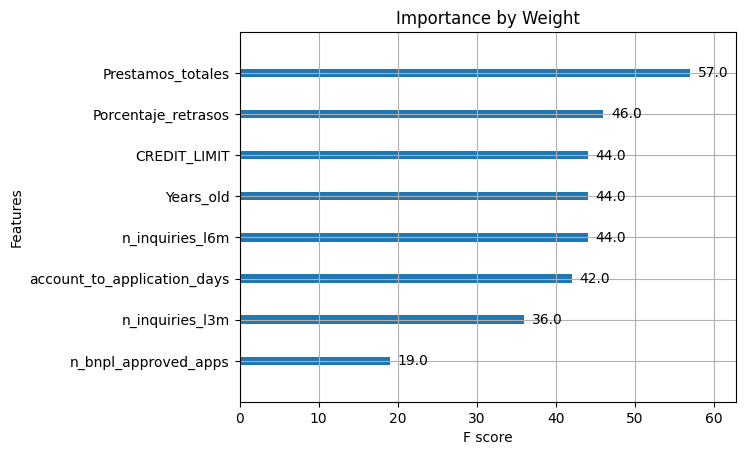

In [368]:
#relevancia de cada variable
# Obtener la importancia usando el método 'get_booster().get_score()'
importance = best_model.get_booster().get_score(importance_type='weight')

# Usar la función plot_importance
plot_importance(booster=best_model, importance_type='weight', title='Importance by Weight')
plt.show()

**REGRESION LOGISTICA**

In [353]:
# Crear una instancia del clasificador y entrenar
# Instancia del modelo
model = LogisticRegression(max_iter=10000)

# Grilla de hiperparámetros
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' es necesario para el penalty 'l1'
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\ProgramData\Anaconda3\envs\Data_Science\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy', verbose=1)

In [354]:
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor precisión alcanzada: {grid_search.best_score_}")

best_model = grid_search.best_estimator_


Mejores hiperparámetros: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Mejor precisión alcanzada: 0.8145695594174296


**NOTA:** Quitar las variables de
- Prestamos por Categoria
- Prevention keys

## 4) Discuciones
Crear un modelo de riesgo financiero es crucial para muchas instituciones financieras. La selección de variables es esencial para la eficacia del modelo. Aquí te dejo 11 variables principales que se suelen considerar en estos modelos:

1. *Historial crediticio*: Registra el comportamiento pasado del cliente en relación con sus créditos anteriores. Los pagos tardíos, los incumplimientos o las quiebras son indicadores de alto riesgo.

2. *Ingreso mensual*: Una medida de la capacidad del cliente para pagar. Un ingreso más alto podría indicar una mayor capacidad de pago.

3. *Ratio de endeudamiento*: Indica cuánto de los ingresos mensuales del cliente ya está comprometido en otros pagos de deuda.

4. *Duración del empleo*: Un empleo estable puede ser indicativo de ingresos regulares y estabilidad financiera.

5. *Edad*: En algunos casos, la edad puede influir en el comportamiento de pago. Por ejemplo, los clientes más jóvenes pueden no tener un historial crediticio establecido.

6. *Número de créditos abiertos*: Tener muchos créditos puede ser tanto un indicador de buena gestión crediticia como de sobreendeudamiento.

7. *Garantías o activos*: La existencia de activos o propiedades que puedan ser utilizadas como garantía reduce el riesgo para el prestamista.

8. *Antigüedad en la vivienda actual*: Una residencia estable puede ser un indicativo de estabilidad general en la vida del cliente.

9. *Estado civil y dependientes*: Estar casado o tener dependientes puede influir en las responsabilidades financieras y, por lo tanto, en el comportamiento de pago.

10. *Tipo de empleo o profesión*: Algunas profesiones pueden estar asociadas con ingresos más estables o más volátiles.

11. *Consulta de crédito reciente*: Si el cliente ha solicitado muchos créditos recientemente, puede ser una señal de desesperación financiera.

Recuerda que, además de seleccionar las variables correctas, es esencial contar con un conjunto de datos de calidad y suficientemente grande para entrenar tu modelo. También es vital realizar un análisis exploratorio de los datos y considerar la posibilidad de interacciones entre variables.